In [1]:
import pandas as pd
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.metrics import roc_auc_score, roc_curve, cohen_kappa_score, precision_score, recall_score, \
    precision_recall_curve

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.semi_supervised import LabelSpreading, LabelPropagation
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.base import clone
import sklearn.preprocessing
import pickle
from tqdm import tqdm

import os
from gensim.models import KeyedVectors
from gensim.downloader import base_dir

import random

/home/g/g01115/.local/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
#Dataframe  generated in analye-data.ipynb
df = pd.read_json("./Trec_data/Preprocessed_labelled.json", orient='records',lines=True)
df

,eventID,eventType,postID,postCategories,postPriority,text,entities,extended_entities,favorite_count,hashtagEntities,...,bool_Weather,bool_Volunteer,bool_Hashtags,bool_OriginalEvent,bool_ContextualInformation,bool_InformationWanted,bool_GoodsServices,bool_SearchAndRescue,bool_Location,sparseCategories
0,fireColorado2012,wildfire,212311994286620672,[MultimediaShare],Unknown,RT @CBSDenver: The copter is on the way to the...,"{'symbols': [], 'urls': [], 'hashtags': [{'tex...",None,0.0,None,...,False,False,False,False,False,False,False,False,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
1,fireColorado2012,wildfire,217746356842926080,[MultimediaShare],Medium,RT @ColoradoRapids: Photo of #FlagStaffFire in...,"{'symbols': [], 'urls': [], 'hashtags': [{'tex...",None,0.0,None,...,False,False,False,False,False,False,False,False,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
2,fireColorado2012,wildfire,217732012314861568,[FirstPartyObservation],Medium,2 wildfires in Boulder County. We can see smok...,"{'symbols': [], 'urls': [], 'hashtags': [], 'u...",None,0.0,None,...,False,False,False,False,False,False,False,False,False,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
3,fireColorado2012,wildfire,216961334129078272,[Discussion],Low,RT @Jon_G3: Seeing 1/3 of Colorado on fire mak...,"{'symbols': [], 'urls': [], 'hashtags': [{'tex...",None,0.0,None,...,False,False,False,False,False,False,False,False,False,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,fireColorado2012,wildfire,212552860590813184,[MultimediaShare],Medium,RT @dhorning11: RT @LarimerCounty: #HighParkFi...,"{'symbols': [], 'urls': [{'expanded_url': 'htt...",None,0.0,None,...,False,False,False,False,False,False,False,False,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38071,tennesseeTornadoOutbreak2020,tornado,1235236359310368768,"[ThirdPartyObservation, Weather, Location, Mul...",Low,Hottest Google Search in 31.2 hrs. Nashville t...,"{'hashtags': [], 'urls': [{'url': 'https://t.c...",None,0.0,None,...,True,False,False,False,True,False,False,False,True,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, ..."
38072,tennesseeTornadoOutbreak2020,tornado,1235337290144239616,"[ThirdPartyObservation, Location, MultimediaSh...",Low,A live report is next on the Nashville tornado...,"{'hashtags': [], 'urls': [], 'user_mentions': ...",None,0.0,None,...,False,False,False,False,False,False,False,False,True,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, ..."
38073,tennesseeTornadoOutbreak2020,tornado,1235258820139638784,"[ThirdPartyObservation, Weather, Location, Mul...",Low,Officials are still cleaning up after tornadoe...,"{'hashtags': [], 'urls': [], 'user_mentions': ...",None,0.0,None,...,True,False,False,False,False,False,False,False,True,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, ..."
38074,tennesseeTornadoOutbreak2020,tornado,1235253249957126144,"[ThirdPartyObservation, Weather, Location, Mul...",Low,Putnam County: Cookeville area tornado victims...,"{'hashtags': [], 'urls': [{'url': 'https://t.c...",None,0.0,None,...,True,False,False,False,False,False,False,False,True,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, ..."


In [11]:
df.columns

Index(['eventID', 'eventType', 'postID', 'postCategories', 'postPriority',
       'text', 'entities', 'extended_entities', 'favorite_count',
       'hashtagEntities', 'inReplyToScreenName', 'inReplyToStatusId',
       'inReplyToUserId', 'isFavorited', 'isRetweeted', 'isTruncated',
       'is_quote_status', 'lang', 'matching_rules', 'mediaEntities',
       'metadata', 'possibly_sensitive', 'retweet_count', 'retweeted_status',
       'truncated', 'user', 'caps_ratio', 'is_retweet', 'is_verified',
       'num_chars', 'num_chars_total', 'num_hashtags', 'num_media',
       'num_mentions', 'num_terms', 'num_unique_words', 'num_urls',
       'num_words', 'vader compound', 'vader neg', 'vader neu', 'vader pos',
       'vectorized_text', 'regression_priority', 'bool_MultimediaShare',
       'bool_FirstPartyObservation', 'bool_Discussion', 'bool_News',
       'bool_Official', 'bool_Sentiment', 'bool_Irrelevant',
       'bool_ServiceAvailable', 'bool_ThirdPartyObservation', 'bool_Factoid',
      

# **`Generate Event Types`**

In [3]:
fullEventTypes = df['eventType'].unique()
eventTypes = []
for event in fullEventTypes:
    events = df.loc[df['eventType'] == event]['eventID'].unique()
    if events.size > 1:
        eventTypes.append(event)
print(eventTypes)

['wildfire', 'earthquake', 'flood', 'typhoon', 'shooting', 'bombing', 'storm']


# **`Model Related Methods`**

In [4]:
def train_data(data, column, heldout_ids):
    if type(heldout_ids) != list:
        heldout_ids = [heldout_ids]
    training = data.loc[~data[column].isin(heldout_ids)]
    
    return training

def test_data(data, column, heldout_ids):
    if type(heldout_ids) != list:
        heldout_ids = [heldout_ids]
    test = data.loc[data[column].isin(heldout_ids)]
    
    return test

In [5]:
def generate_scores_by_event(data, event, features, target, modelType):
    f1_accum = []
    accuracy_accum = []
    eventIDs = data.loc[data['eventType']==event]['eventID'].unique()
    for heldoutEvent in tqdm(eventIDs, position=1,desc=event):
        #Create training and test dataframe
        training = train_data(data, 'eventID', heldoutEvent)
        test = test_data(data, 'eventID', heldoutEvent)
        
        X_train = training[features]
        y_train = training[target]        
        X_test = test[features]
        y_test = test[target]
        
        if isinstance(y_train, pd.Series):
            y_train = []
            for val in training[target]:
                y_train.append(np.array(val))
            y_train= np.array(y_train)
        if isinstance(y_test, pd.Series):
            y_test = []
            for val in test[target]:
                y_test.append(np.array(val))
            y_test= np.array(y_test)
            
        
        #generate model
        model = clone(modelType)
        model.fit(X_train, y_train)
        #model = generate_model(training, features, target, modelType)
        
        #Test model
        y_infer_local = model.predict(X_test)
        local_f1 = f1_score(y_test, y_infer_local, average="macro", zero_division=0) #Should the average be changed?
        local_score = model.score(X_test, y_test)
        
        accuracy_accum.append(local_score)
        f1_accum.append(local_f1)
        
    return [accuracy_accum, f1_accum] #Accuracy is 0, F1 is 1

In [15]:
#Currently unused
def save_model(model, filename):
    pickle.dump(model, open(filename, 'wb'))
    
def load_model(filename):
    model = pickle.load(open(filename, 'rb'))
    return model

# **`Generate Generic Variables`**

In [6]:
features = ["num_chars", "num_chars_total", 
            "num_terms", "num_words", "num_unique_words", "vader neg", "vader pos",
            "vader neu", "vader compound", 
            "num_hashtags", "num_mentions", 
            "num_urls", 
            "is_retweet", "num_media",
            "is_verified", 
            "caps_ratio"] #, "vectorized_text"]

#I think you need to make a list of lists

rf_params = {
    'random_state': 1337,
    'class_weight': 'balanced',
    'n_estimators': 128, 
    'n_jobs': -1,
    'max_depth': 50,
    'max_features': 14,
    'min_samples_leaf': 33,
    'min_samples_split': 96,
    'verbose': 0
}

# **`Generate and Test postPriority Models`**

In [29]:
water_types = ['typhoon', 'storm', 'flood']

In [31]:
prioLabel = 'postPriority'
prioModel = RandomForestClassifier(**rf_params) #(**modelParameters)

genPrioScores = {}
specPrioScores = {}

#generate general model
for event in tqdm(water_types, position=0, desc='Events'):
    #print('Event: ' + event)
    eventDF = df.loc[df['eventType']==event]
    genPrioScores[event] = generate_scores_by_event(df, event, features, prioLabel, prioModel)
    specPrioScores[event] = generate_scores_by_event(eventDF, event, features, prioLabel, prioModel)
    

typhoon: 100%|██████████| 9/9 [02:04<00:00, 13.86s/it]

storm: 100%|██████████| 2/2 [00:28<00:00, 14.19s/it]

flood: 100%|██████████| 11/11 [02:33<00:00, 13.95s/it]

Events: 100%|██████████| 3/3 [05:39<00:00, 113.21s/it]


In [32]:
#Store prio scores in readable format
prioScoreDf = pd.DataFrame(columns=['genScores', 'specScores',
                                    'avgAccGen', 'avgAccSpec', 'avgF1Gen', 'avgF1Spec',
                                    'stdAccGen', 'stdAccSpec', 'stdF1Gen', 'stdF1Spec'])
for event in water_types:
    row = pd.Series(
        {
            'genScores': genPrioScores[event], 'specScores': specPrioScores[event],
            'avgAccGen': np.mean(genPrioScores[event][0]), 'avgAccSpec': np.mean(specPrioScores[event][0]),
            'avgF1Gen': np.mean(genPrioScores[event][1]), 'avgF1Spec': np.mean(specPrioScores[event][1]),
            'stdAccGen': np.std(genPrioScores[event][0]), 'stdAccSpec': np.std(specPrioScores[event][0]),
            'stdF1Gen': np.std(genPrioScores[event][1]), 'stdF1Spec': np.std(specPrioScores[event][1])
        }, name=event)
    prioScoreDf = prioScoreDf.append(row)
    
prioScoreDf

,genScores,specScores,avgAccGen,avgAccSpec,avgF1Gen,avgF1Spec,stdAccGen,stdAccSpec,stdF1Gen,stdF1Spec
typhoon,"[[0.4606741573033708, 0.38209606986899564, 0.4...","[[0.5056179775280899, 0.3864628820960699, 0.41...",0.388729,0.474315,0.208310,0.243035,0.081501,0.077312,0.070284,0.058649
storm,"[[0.4433497536945813, 0.37333333333333335], [0...","[[0.18226600985221675, 0.37333333333333335], [...",0.408342,0.277800,0.298814,0.230705,0.035008,0.095534,0.031746,0.055244
flood,"[[0.46994535519125685, 0.363013698630137, 0.38...","[[0.4644808743169399, 0.4041095890410959, 0.34...",0.385024,0.451105,0.204074,0.237013,0.084920,0.104282,0.087530,0.071933


In [33]:
#Save prio scores
prioScoreDf.to_json("./Trec_data/water_prioScoreDF.json")

filename = './Trec_data/water_prio_results.pkl'
outfile = open(filename,'wb')
pickle.dump(prioScoreDf, outfile)
outfile.close()

In [34]:
prioScoreDf = pd.read_json("./Trec_data/water_prioScoreDF.json")
prioScoreDf

import matplotlib.pyplot as plt
from math import sqrt

prioScoreDf['n'] = [12, 13, 2]

prioDF = prioScoreDf
prioDF

,genScores,specScores,avgAccGen,avgAccSpec,avgF1Gen,avgF1Spec,stdAccGen,stdAccSpec,stdF1Gen,stdF1Spec,n
typhoon,"[[0.4606741573, 0.3820960699, 0.4342105263, 0....","[[0.5056179775, 0.3864628821, 0.4144736842, 0....",0.388729,0.474315,0.208310,0.243035,0.081501,0.077312,0.070284,0.058649,12
storm,"[[0.4433497537, 0.3733333333], [0.3305603022, ...","[[0.1822660099, 0.3733333333], [0.1754611262, ...",0.408342,0.277800,0.298814,0.230705,0.035008,0.095534,0.031746,0.055244,13
flood,"[[0.4699453552, 0.3630136986, 0.3856812933, 0....","[[0.4644808743, 0.40410958900000005, 0.3418013...",0.385024,0.451105,0.204074,0.237013,0.084920,0.104282,0.087530,0.071933,2


In [35]:
ste_prio_gen = []
ste_prio_spec = []
ste_prio_genacc = []
ste_prio_specacc = []


for row in prioDF.itertuples():
    F1Gen = row.stdF1Gen
    F1Spec = row.stdF1Spec
    F1Genacc = row.stdAccGen
    F1Specacc = row.stdAccSpec
    steGen = F1Gen / sqrt(row.n)
    steSpec = F1Spec / sqrt(row.n)
    steGenacc = F1Genacc / sqrt(row.n)
    steSpecacc = F1Specacc / sqrt(row.n)
    ste_prio_gen.append(steGen)
    ste_prio_spec.append(steSpec)
    ste_prio_genacc.append(steGenacc)
    ste_prio_specacc.append(steSpecacc)
    print('Priority Event:', row[0], 'Gen:', steGen, 'Spec:', steSpec, 'GenAcc:', steGenacc, 'SpecAcc:', steSpecacc)

Priority Event: typhoon Gen: 0.020289203842308496 Spec: 0.01693055649514131 GenAcc: 0.02352717438883762 SpecAcc: 0.02231812172083918
Priority Event: storm Gen: 0.008804797928137818 Spec: 0.015321801932463392 GenAcc: 0.009709530533717035 SpecAcc: 0.02649627044555233
Priority Event: flood Gen: 0.0618931341268724 Spec: 0.050864575629789265 GenAcc: 0.06004727034119381 SpecAcc: 0.07373847675807294


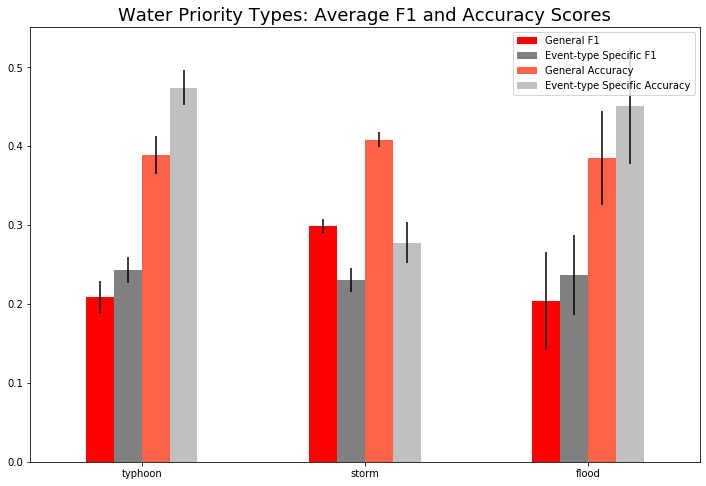

In [38]:
#priority results

plt.figure(figsize=(12, 8))
ax = plt.axes()

genF1 = [item for item in prioDF['avgF1Gen']]
ste_gen = [item for item in ste_prio_gen]
ste_spec = [item for item in ste_prio_spec]
specF1 = [item for item in prioDF['avgF1Spec']]
index = [item for item in prioDF.index]

genacc = [item for item in prioDF['avgAccGen']]
specacc = [item for item in prioDF['avgAccSpec']]
ste_genacc = [item for item in ste_prio_genacc]
ste_specacc = [item for item in ste_prio_specacc]

df_prio = pd.DataFrame({'General F1': genF1,

                   'Event-type Specific F1': specF1, 'General Accuracy': genacc, 
                        
                    'Event-type Specific Accuracy': specacc}, index=index)

ax.set_title('Water Priority Types: Average F1 and Accuracy Scores', fontsize = 18)
ax = df_prio.plot.bar(rot=0, ax=ax, yerr = [ste_gen, ste_spec, ste_genacc, ste_specacc], 
                      color=['red', 'grey', 'tomato', 'silver'])

plt.show()

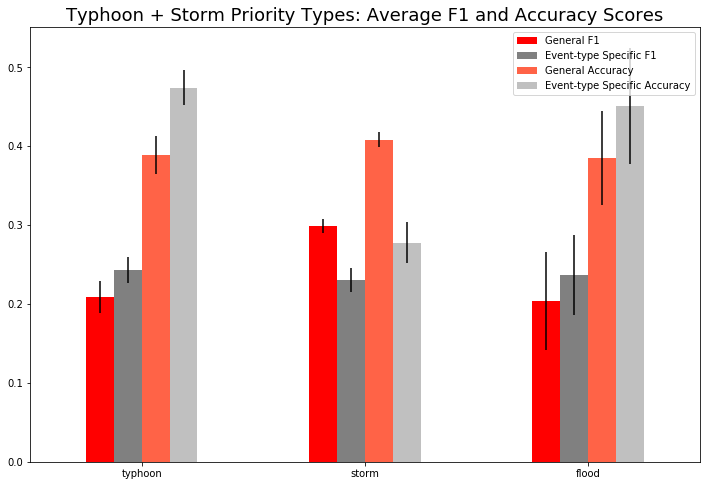

In [39]:
#priority results

plt.figure(figsize=(12, 8))
ax = plt.axes()

genF1 = [item for item in prioDF['avgF1Gen']]
ste_gen = [item for item in ste_prio_gen]
ste_spec = [item for item in ste_prio_spec]
specF1 = [item for item in prioDF['avgF1Spec']]
index = [item for item in prioDF.index]

genacc = [item for item in prioDF['avgAccGen']]
specacc = [item for item in prioDF['avgAccSpec']]
ste_genacc = [item for item in ste_prio_genacc]
ste_specacc = [item for item in ste_prio_specacc]

df_prio = pd.DataFrame({'General F1': genF1,

                   'Event-type Specific F1': specF1, 'General Accuracy': genacc, 
                        
                    'Event-type Specific Accuracy': specacc}, index=index)

ax.set_title('Typhoon + Storm Priority Types: Average F1 and Accuracy Scores', fontsize = 18)
ax = df_prio.plot.bar(rot=0, ax=ax, yerr = [ste_gen, ste_spec, ste_genacc, ste_specacc], 
                      color=['red', 'grey', 'tomato', 'silver'])

plt.show()

# **`Generate and Test postCategories Models`**

In [21]:
catLabel = 'sparseCategories'
catModel = MultiOutputClassifier(RandomForestClassifier(**rf_params))

genCatScores = {}
specCatScores = {}

#generate general model
for event in tqdm(eventTypes, position=0, desc='Events'):
    #print('Event: ' + event)
    eventDF = df.loc[df['eventType']==event]
    genCatScores[event] = generate_scores_by_event(df, event, features, catLabel, catModel)
    specCatScores[event] = generate_scores_by_event(eventDF, event, features, catLabel, catModel)


wildfire: 100%|██████████| 5/5 [24:40<00:00, 296.12s/it]

earthquake: 100%|██████████| 11/11 [59:27<00:00, 324.35s/it]

flood: 100%|██████████| 11/11 [54:48<00:00, 298.97s/it]

typhoon: 100%|██████████| 9/9 [44:15<00:00, 295.08s/it]

shooting: 100%|██████████| 10/10 [49:26<00:00, 296.65s/it]

bombing: 100%|██████████| 3/3 [14:51<00:00, 297.06s/it]

storm: 100%|██████████| 2/2 [09:58<00:00, 299.11s/it]

Events: 100%|██████████| 7/7 [4:45:27<00:00, 2446.76s/it]


In [22]:
#Store cat scores in readable format
catScoreDf = pd.DataFrame(columns=['genScores', 'specScores',
                                   'avgAccGen', 'avgAccSpec', 'avgF1Gen', 'avgF1Spec',
                                   'stdAccGen', 'stdAccSpec', 'stdF1Gen', 'stdF1Spec'])
for event in eventTypes:
    row = pd.Series(
        {
            'genScores': genCatScores[event], 'specScores': specCatScores[event],
            'avgAccGen': np.mean(genCatScores[event][0]), 'avgAccSpec': np.mean(specCatScores[event][0]),
            'avgF1Gen': np.mean(genCatScores[event][1]), 'avgF1Spec': np.mean(specCatScores[event][1]),
            'stdAccGen': np.std(genCatScores[event][0]), 'stdAccSpec': np.std(specCatScores[event][0]),
            'stdF1Gen': np.std(genCatScores[event][1]), 'stdF1Spec': np.std(specCatScores[event][1])
        }, name=event)
    catScoreDf = catScoreDf.append(row)
    
catScoreDf

,genScores,specScores,avgAccGen,avgAccSpec,avgF1Gen,avgF1Spec,stdAccGen,stdAccSpec,stdF1Gen,stdF1Spec
wildfire,"[[0.006535947712418301, 0.0017825311942959, 0....","[[0.006535947712418301, 0.0017825311942959, 0....",0.021559,0.002500,0.153854,0.139205,0.020001,0.002177,0.040578,0.034574
earthquake,"[[0.01694915254237288, 0.01818181818181818, 0....","[[0.005649717514124294, 0.00909090909090909, 0...",0.028901,0.010777,0.125732,0.117239,0.022097,0.009528,0.043702,0.036152
flood,"[[0.02185792349726776, 0.0, 0.0023094688221709...","[[0.01092896174863388, 0.0, 0.0, 0.00334448160...",0.047879,0.048423,0.141255,0.131016,0.057599,0.065098,0.055937,0.053121
typhoon,"[[0.0056179775280898875, 0.013100436681222707,...","[[0.0056179775280898875, 0.004366812227074236,...",0.042040,0.019895,0.132398,0.122341,0.028210,0.010345,0.067420,0.055603
shooting,"[[0.007462686567164179, 0.001483679525222552, ...","[[0.007462686567164179, 0.002967359050445104, ...",0.086057,0.117026,0.136266,0.131367,0.081442,0.118685,0.045523,0.044265
bombing,"[[0.03333333333333333, 0.02564102564102564, 0....","[[0.0, 0.022435897435897436, 0.000694444444444...",0.027297,0.007710,0.143216,0.113067,0.004411,0.010417,0.030101,0.025661
storm,"[[0.013136288998357963, 0.0], [0.2170454200136...","[[0.0, 0.0], [0.16055900712677387, 0.202134446...",0.006568,0.000000,0.213506,0.181347,0.006568,0.000000,0.003539,0.020788


In [23]:
#Save cat scores
catScoreDf.to_json("./Trec_data/catScoreDF.json")

filename = './Trec_data/cat_results.pkl'
outfile = open(filename,'wb')
pickle.dump(catScoreDf,outfile)
outfile.close()

In [24]:
catScoreDf = pd.read_json("./Trec_data/catScoreDF.json")
catScoreDf

,genScores,specScores,avgAccGen,avgAccSpec,avgF1Gen,avgF1Spec,stdAccGen,stdAccSpec,stdF1Gen,stdF1Spec
wildfire,"[[0.0065359477, 0.0017825312, 0.0084937712, 0....","[[0.0065359477, 0.0017825312, 0.0016987542, 0....",0.021559,0.002500,0.153854,0.139205,0.020001,0.002177,0.040578,0.034574
earthquake,"[[0.016949152500000002, 0.0181818182, 0.015151...","[[0.0056497175, 0.0090909091, 0.0, 0.019379845...",0.028901,0.010777,0.125732,0.117239,0.022097,0.009528,0.043702,0.036152
flood,"[[0.0218579235, 0.0, 0.0023094688, 0.010033444...","[[0.0109289617, 0.0, 0.0, 0.0033444816, 0.0123...",0.047879,0.048423,0.141255,0.131016,0.057599,0.065098,0.055937,0.053121
typhoon,"[[0.0056179775, 0.0131004367, 0.03947368420000...","[[0.0056179775, 0.0043668122, 0.02631578950000...",0.042040,0.019895,0.132398,0.122341,0.028210,0.010345,0.067420,0.055603
shooting,"[[0.007462686600000001, 0.0014836795, 0.083973...","[[0.007462686600000001, 0.0029673591, 0.059275...",0.086057,0.117026,0.136266,0.131367,0.081442,0.118685,0.045523,0.044265
bombing,"[[0.033333333300000004, 0.025641025600000002, ...","[[0.0, 0.0224358974, 0.0006944444], [0.0829538...",0.027297,0.007710,0.143216,0.113067,0.004411,0.010417,0.030101,0.025661
storm,"[[0.013136289, 0.0], [0.21704542000000002, 0.2...","[[0.0, 0.0], [0.1605590071, 0.2021344467]]",0.006568,0.000000,0.213506,0.181347,0.006568,0.000000,0.003539,0.020788


# Visualizing Data

In [ ]:
import matplotlib.pyplot as plt
from math import sqrt

prioScoreDf['n'] = [5, 11, 12, 13, 10, 3, 2]
catScoreDf['n'] = [5, 11, 12, 13, 10, 3, 2]

prioDf = prioScoreDf
catDf = catScoreDf

In [ ]:
#standard error

ste_cat_gen = []
ste_cat_spec = []

ste_prio_gen = []
ste_prio_spec = []
ste_prio_genacc = []
ste_prio_specacc = []

for row in catDF.itertuples():
    F1Gen = row.stdF1Gen
    F1Spec = row.stdF1Spec
    steGen = F1Gen / sqrt(row.n)
    steSpec = F1Spec / sqrt(row.n)
    ste_cat_gen.append(steGen)
    ste_cat_spec.append(steSpec)
    print('Event:', row[0], 'Gen:', steGen, 'Spec:', steSpec)
    
for row in prioDF.itertuples():
    F1Gen = row.stdF1Gen
    F1Spec = row.stdF1Spec
    F1Genacc = row.stdAccGen
    F1Specacc = row.stdAccSpec
    steGen = F1Gen / sqrt(row.n)
    steSpec = F1Spec / sqrt(row.n)
    steGenacc = F1Genacc / sqrt(row.n)
    steSpecacc = F1Specacc / sqrt(row.n)
    ste_prio_gen.append(steGen)
    ste_prio_spec.append(steSpec)
    ste_prio_genacc.append(steGenacc)
    ste_prio_specacc.append(steSpecacc)
    print('Priority Event:', row[0], 'Gen:', steGen, 'Spec:', steSpec, 'GenAcc:', steGenacc, 'SpecAcc:', steSpecacc)

In [ ]:
#priority results

plt.figure(figsize=(12, 8))
ax = plt.axes()

genF1 = [item for item in prioDF['avgF1Gen']]
ste_gen = [item for item in ste_prio_gen]
ste_spec = [item for item in ste_prio_spec]
specF1 = [item for item in prioDF['avgF1Spec']]
index = [item for item in prioDF.index]

genacc = [item for item in prioDF['avgAccGen']]
specacc = [item for item in prioDF['avgAccSpec']]
ste_genacc = [item for item in ste_prio_genacc]
ste_specacc = [item for item in ste_prio_specacc]

df_prio = pd.DataFrame({'General F1': genF1,

                   'Event-type Specific F1': specF1, 'General Accuracy': genacc, 
                        
                    'Event-type Specific Accuracy': specacc}, index=index)

ax.set_title('Priority Types: Average F1 and Accuracy Scores', fontsize = 18)
ax = df_prio.plot.bar(rot=0, ax=ax, yerr = [ste_gen, ste_spec, ste_genacc, ste_specacc], 
                      color=['red', 'grey', 'tomato', 'silver'])

plt.show()

In [ ]:
#category results

plt.figure(figsize=(12, 8))

ax = plt.axes()

catgenF1 = [item for item in catDF['avgF1Gen']]
catspecF1 = [item for item in catDF['avgF1Spec']]
ste_gencat = [item for item in ste_cat_gen]
ste_speccat = [item for item in ste_cat_spec]
index = [item for item in catDF.index]

df2 = pd.DataFrame({'General F1': catgenF1,

                   'Event-type Specific F1': catspecF1}, index=index)

ax.set_title('Information Types: Average F1 Scores', fontsize = 18)

ax = df2.plot.bar(rot=0, ax=ax, yerr = [ste_gencat, ste_speccat], color=['red', 'darkgrey'])
plt.show()